In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import joblib

In [3]:
df = pd.read_csv('/content/diabetes.csv')
print("Loaded dataset:", '/content/diabetes.csv')
print("Shape:", df.shape)
display(df.head())

Loaded dataset: /content/diabetes.csv
Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print(df.isnull().sum().sum())


0


In [5]:
print("\n--- Dataset info ---")
df.info()
print("\n--- Target distribution (Outcome) ---")
print(df['Outcome'].value_counts())


--- Dataset info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

--- Target distribution (Outcome) ---
Outcome
0    500
1    268
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

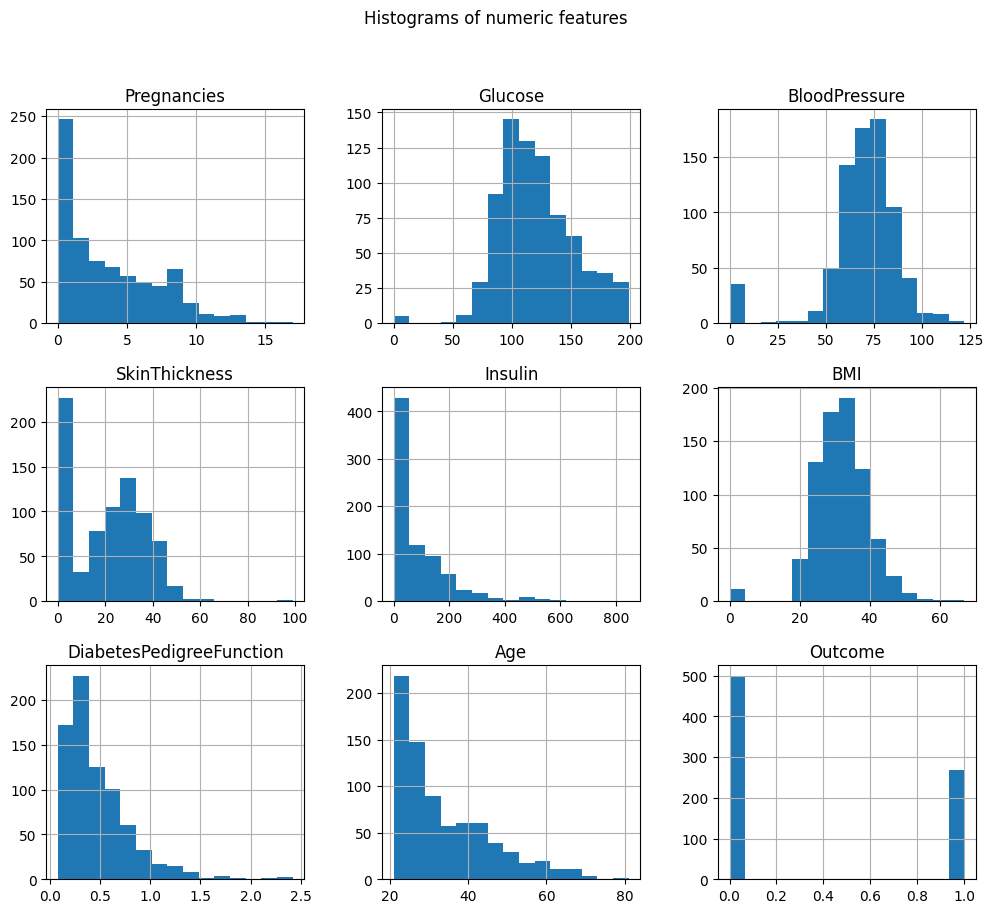

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=15, figsize=(12, 10))
plt.suptitle("Histograms of numeric features")
plt.show()

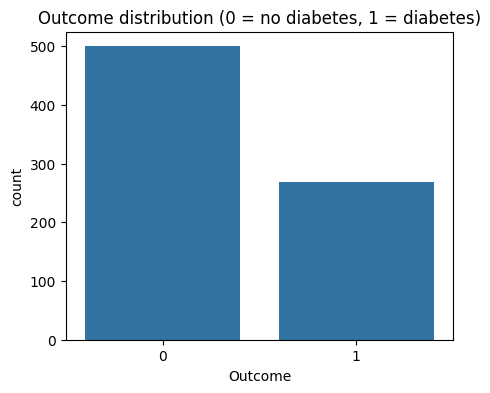

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x='Outcome', data=df)
plt.title("Outcome distribution (0 = no diabetes, 1 = diabetes)")
plt.show()

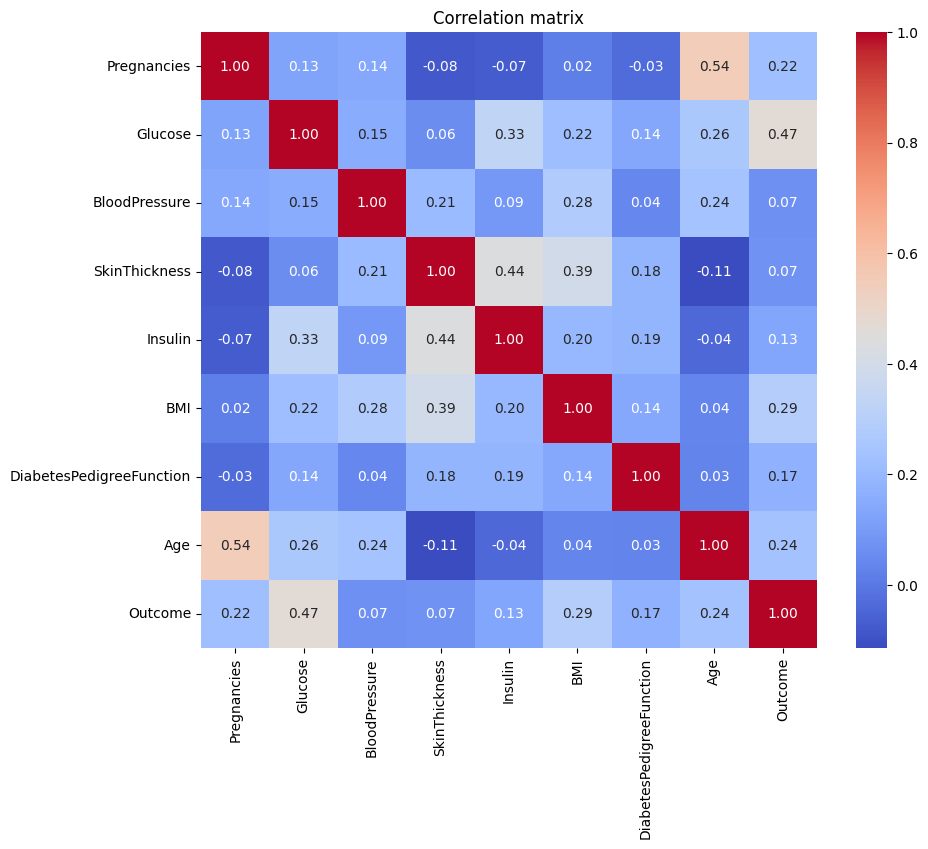

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.show()


In [9]:
# Common diabetes datasets have zeros in some features which are invalid - replace with median
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [10]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for c in zero_cols:
    if c in X.columns:
        zeros = (X[c] == 0).sum()
        if zeros > 0:
            med = X.loc[X[c] != 0, c].median()
            X.loc[X[c] == 0, c] = med
            print(f"Replaced {zeros} zeros in '{c}' with median {med}")


Replaced 5 zeros in 'Glucose' with median 117.0
Replaced 35 zeros in 'BloodPressure' with median 72.0
Replaced 227 zeros in 'SkinThickness' with median 29.0
Replaced 374 zeros in 'Insulin' with median 125.0
Replaced 11 zeros in 'BMI' with median 32.3


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [12]:
# Build pipelines (scaling + model)
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # scaling isn't necessary for RF, but keeps both pipelines consistent
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

models = {
    'LogisticRegression': pipe_lr,
    'RandomForest': pipe_rf
}


In [14]:
# Train & evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    print(f"\n{name} results:")
    print(f" Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC_AUC: {auc:.4f}" if auc is not None else "")
    print(" Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))





LogisticRegression results:
 Accuracy: 0.7078  Precision: 0.6000  Recall: 0.5000  F1: 0.5455  ROC_AUC: 0.8130
 Confusion matrix:
 [[82 18]
 [27 27]]

Classification report:
               precision    recall  f1-score   support

           0     0.7523    0.8200    0.7847       100
           1     0.6000    0.5000    0.5455        54

    accuracy                         0.7078       154
   macro avg     0.6761    0.6600    0.6651       154
weighted avg     0.6989    0.7078    0.7008       154


RandomForest results:
 Accuracy: 0.7403  Precision: 0.6522  Recall: 0.5556  F1: 0.6000  ROC_AUC: 0.8161
 Confusion matrix:
 [[84 16]
 [24 30]]

Classification report:
               precision    recall  f1-score   support

           0     0.7778    0.8400    0.8077       100
           1     0.6522    0.5556    0.6000        54

    accuracy                         0.7403       154
   macro avg     0.7150    0.6978    0.7038       154
weighted avg     0.7337    0.7403    0.7349       154



In [15]:
# 6) Compare models in a small table
compare = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1': res['f1'],
        'ROC_AUC': res['roc_auc']
    } for name, res in results.items()
])
display(compare.sort_values('Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,RandomForest,0.740260,0.652174,0.555556,0.600000,0.816111
0,LogisticRegression,0.707792,0.600000,0.500000,0.545455,0.812963


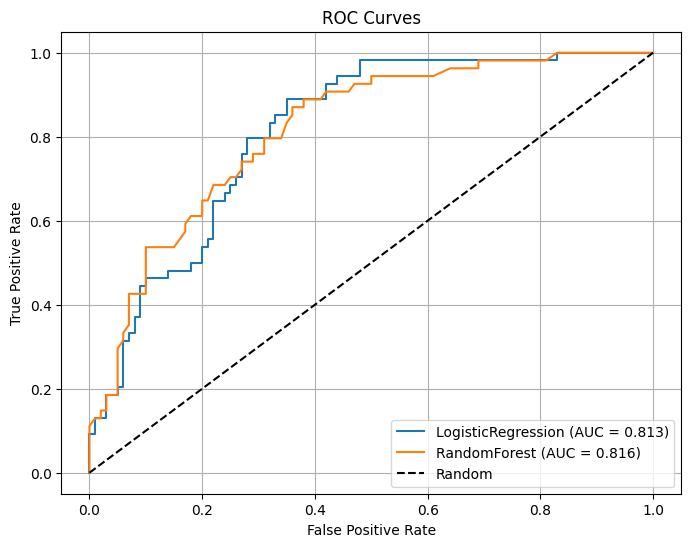

In [16]:
plt.figure(figsize=(8,6))
for name, res in results.items():
    y_proba = res['y_proba']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = res['roc_auc']
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
best_name = max(results.keys(), key=lambda k: results[k]['f1'])
best_model = results[best_name]['model']
save_path = "/content/best_diabetes_model.pkl"
joblib.dump({'model_name': best_name, 'model': best_model}, save_path)
print(f"\nBest model ({best_name}) saved to: {save_path}")


Best model (RandomForest) saved to: /content/best_diabetes_model.pkl


In [19]:
sample_X = X_test.iloc[[-1]]
sample_y = y_test.iloc[-1]
loaded = joblib.load(save_path)
loaded_model = loaded['model']
pred = loaded_model.predict(sample_X)[0]
proba = loaded_model.predict_proba(sample_X)[0][1] if hasattr(loaded_model, "predict_proba") else None

print("\nSample input (features):")
display(sample_X)
print("True label:", int(sample_y))
print("Predicted label:", int(pred))
if proba is not None:
    print("Predicted probability for class=1:", float(proba))



Sample input (features):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
273,1,71,78,50,45,33.2,0.422,21


True label: 0
Predicted label: 0
Predicted probability for class=1: 0.055
